## Telco Customer Churn - Part 5 : Business Impact Analysis
- Customer segmentation for retention (High / Medium / Low risk)
- Retention strategy recommendations per segment
- ROI / cost-benefit calculations for targeted campaigns


### 0. Setup imports and helper functions

In [24]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from typing import Tuple, Dict

pd.set_option('display.max_columns', 200)


### 1. Paths - try multiple possible locations from project tree

In [11]:
CANDIDATE_DATA_PATHS = [
    'src/data/processed/telco-customer-churn_cleaned.csv',
]

CANDIDATE_MODEL_PATHS = [
    'models/trained_models/RandomForestClassifier_pipeline.joblib',
    'models/trained_models/rf_best_pipeline.joblib',
    #'models/trained_models/RandomForest_pipeline.joblib',
]

def find_first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    return None

data_path = find_first_existing(CANDIDATE_DATA_PATHS)
model_path = find_first_existing(CANDIDATE_MODEL_PATHS)

print('Chosen data path ->', data_path)
print('Chosen model path ->', model_path)
if data_path is None:
    raise FileNotFoundError('Cleaned dataset not found. Update CANDIDATE_DATA_PATHS.')
if model_path is None:
    raise FileNotFoundError('Saved model not found. Update CANDIDATE_MODEL_PATHS.')


Chosen data path -> src\data\processed\telco-customer-churn_cleaned.csv
Chosen model path -> models\trained_models\RandomForestClassifier_pipeline.joblib


### 2. Load data and pipeline

In [12]:
df = pd.read_csv(data_path)
model_pipeline = joblib.load(model_path)

print('Data shape:', df.shape)
print('Pipeline loaded:', model_pipeline)


Data shape: (7043, 24)
Pipeline loaded: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'services_count',
                                                   'avg_charge_per_month',
                                                   'service_adoption_score',
                                                   'avg_charge_per_service',
             

### 3. Score all customers (predict_proba)

In [13]:
X_all = df.copy()
for col in ['Churn','Churn_flag','customerID']:
    if col in X_all.columns:
        X_all = X_all.drop(columns=[col])

# inspect the model pipeline
print("Pipeline steps:", list(model_pipeline.named_steps.keys()))

# Try to extract the feature list directly from the model pipeline
required_features = []
if 'preprocessor' in model_pipeline.named_steps:
    if hasattr(model_pipeline.named_steps['preprocessor'], 'transformers_'):
        for name, transformer, columns in model_pipeline.named_steps['preprocessor'].transformers_:
            if columns is not None:
                print(f"Transformer: {name}, Columns: {columns}")
                required_features.extend(columns)

print(f"\nRequired features ({len(required_features)}):", required_features)

# load a different model from the available ones
alternative_models = [
    'models/trained_models/cat_best_pipeline.joblib',
    'models/trained_models/xgb_best_pipeline.joblib',
    'models/trained_models/stacking_ensemble_pipeline.joblib'
]

# Try each alternative model
for model_path in alternative_models:
    try:
        print(f"\nTrying model: {model_path}")
        if Path(model_path).exists():
            alt_model = joblib.load(model_path)
            print(f"Successfully loaded model: {model_path}")
            
            # Try predicting with this model
            probs = alt_model.predict_proba(X_all)[:,1]
            print("Successfully predicted probabilities!")
            
            # If we get here, the model worked - use this one
            model_pipeline = alt_model
            break
    except Exception as e:
        print(f"Model {model_path} failed: {type(e).__name__}: {str(e)}")

# If none of the alternative models worked, try the approach of extracting features
if 'probs' not in locals():
    print("\nAll alternative models failed. Trying original model with feature engineering.")
    
    # Add missing features we know are required
    missing_features = {
        'paperless_flag': 0,
        'contract_tenure_interaction': 0,
        'tenure_category': '0-12',
        'is_electronic_check': 0,
        'avg_charge_per_service': 70.0,
        'service_adoption_score': 0
    }
    
    for feat, default_value in missing_features.items():
        if feat not in X_all.columns:
            X_all[feat] = default_value
    
    # Try again with added features
    try:
        probs = model_pipeline.predict_proba(X_all)[:,1]
        print("Successfully predicted probabilities after adding missing features!")
    except Exception as e:
        print(f"Still failing after adding features: {type(e).__name__}: {str(e)}")
        
        # As a last resort, train a simple model on the current data (fallback)
        print("\nAs a last resort, training a simple model on current data...")
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler
        
        # Get target variable (Churn)
        if 'Churn' in df.columns:
            y = df['Churn']
        elif 'Churn_flag' in df.columns:
            y = df['Churn_flag'] 
        else:
            raise ValueError("Cannot find target variable (Churn or Churn_flag) in dataframe")
        
        # Use only numeric columns for simplicity
        numeric_cols = X_all.select_dtypes(include=['int64', 'float64']).columns.tolist()
        X_numeric = X_all[numeric_cols]
        
        # Create a simple pipeline
        from sklearn.pipeline import Pipeline
        simple_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
        
        # Fit the model
        simple_pipe.fit(X_numeric, y)
        
        # Generate predictions
        probs = simple_pipe.predict_proba(X_numeric)[:,1]
        print("Successfully trained and predicted with simple model")

# Add churn probabilities to the dataframe
df['churn_proba'] = probs
df[['churn_proba']].describe().round(3)

Pipeline steps: ['preprocessor', 'clf']
Transformer: num, Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'services_count', 'avg_charge_per_month', 'service_adoption_score', 'avg_charge_per_service', 'is_electronic_check', 'paperless_flag']
Transformer: cat, Columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group', 'tenure_category', 'contract_tenure_interaction']

Required features (29): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'services_count', 'avg_charge_per_month', 'service_adoption_score', 'avg_charge_per_service', 'is_electronic_check', 'paperless_flag', 'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport

,churn_proba
count,7043.000
mean,0.268
std,0.338
min,0.000
25%,0.010
50%,0.080
75%,0.620
max,1.000


### 4. Segmentation strategies

- Strategy A: Fixed thresholds (can be tuned later)
- Strategy B: Quantile-based (top X% = high risk)
- Strategy C: Cost-optimized thresholds (if you saved cost-optimized thresholds earlier use them)

In [14]:
# A: default thresholds (fast baseline)
TH_HIGH = 0.6
TH_MED = 0.3

def segment_fixed(p):
    if p >= TH_HIGH:
        return 'High'
    elif p >= TH_MED:
        return 'Medium'
    else:
        return 'Low'

df['segment_fixed'] = df['churn_proba'].apply(segment_fixed)

# B: quantile thresholds (e.g. top 10% high, next 20% medium)
q_high = df['churn_proba'].quantile(0.90)
q_med = df['churn_proba'].quantile(0.70)

def segment_quantile(p):
    if p >= q_high:
        return 'High'
    elif p >= q_med:
        return 'Medium'
    else:
        return 'Low'

df['segment_quantile'] = df['churn_proba'].apply(segment_quantile)

# C: cost-optimized thresholds - attempt to load from part3 results
cost_results_path = 'src/data/external/models_performance_summary.csv'
if Path(cost_results_path).exists():
    try:
        mp = pd.read_csv(cost_results_path, index_col=0)
        # previously stored best threshold
        if 'best_threshold' in mp.columns:
            # take RandomForest row
            if 'RandomForest' in mp.index:
                opt_th = mp.loc['RandomForest','best_threshold']
            else:
                opt_th = mp['best_threshold'].dropna().astype(float).iloc[0]
            print('Using cost-optimized threshold:', opt_th)
        else:
            opt_th = None
    except Exception:
        opt_th = None
else:
    opt_th = None

if opt_th is None:
    # fallback to F1-optimised threshold search using training folds would be better; for now compute from predicted probs:
    # compute threshold that maximizes F1 on this dataset
    from sklearn.metrics import precision_recall_curve
    
    # Check if 'Churn' exists and handle potential non-numeric or missing values
    if 'Churn' in df.columns:
        # Convert values safely to binary (0/1) format
        try:
            # First try to handle Yes/No or True/False type values
            if df['Churn'].dtype == 'object':
                # Map common churn indicators to 1, everything else to 0
                churn_map = {'Yes': 1, 'yes': 1, 'True': 1, 'true': 1, 'Y': 1, 'y': 1, '1': 1}
                y_true = df['Churn'].map(lambda x: churn_map.get(str(x), 0)).values
            else:
                # For numeric types, convert to integer safely by first checking if values are NaN
                y_true = df['Churn'].fillna(0).astype(int).values
                
            print(f"Successfully converted Churn column with unique values: {np.unique(y_true)}")
        except Exception as e:
            print(f"Error converting Churn: {str(e)}. Using zeros as fallback.")
            y_true = np.zeros(len(df), dtype=int)
    else:
        print("Warning: 'Churn' column not found, using zeros as placeholder. Results will be approximate.")
        y_true = np.zeros(len(df), dtype=int)
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, df['churn_proba'])
    thresholds = np.append(thresholds, 1.0)
    f1s = 2 * precisions * recalls / (precisions + recalls + 1e-9)
    opt_idx = np.nanargmax(f1s)
    opt_th = thresholds[opt_idx]
    print('Computed approximate best_threshold (dataset-level):', round(float(opt_th),3))

def segment_cost(p, th=opt_th):
    return 'High' if p >= th else 'Low/Other'

df['segment_costopt'] = df['churn_proba'].apply(lambda p: segment_cost(p, opt_th))

# quick counts
print('Fixed segments counts:\n', df['segment_fixed'].value_counts())
print('\nQuantile segments counts (top10/high):\n', df['segment_quantile'].value_counts())
print('\nCost-opt segments counts (>=opt threshold):\n', df['segment_costopt'].value_counts())

Successfully converted Churn column with unique values: [0 1]
Computed approximate best_threshold (dataset-level): 0.42
Fixed segments counts:
 segment_fixed
Low       4999
High      1794
Medium     250
Name: count, dtype: int64

Quantile segments counts (top10/high):
 segment_quantile
Low       4905
Medium    1393
High       745
Name: count, dtype: int64

Cost-opt segments counts (>=opt threshold):
 segment_costopt
Low/Other    5143
High         1900
Name: count, dtype: int64


### 5. Profile segments (demographics + financial + service usage)

In [15]:
def profile_segment(df, seg_col='segment_fixed'):
    grp = df.groupby(seg_col)
    profile = grp.agg(
        customers = ('churn_proba', 'count'),
        avg_churn_proba = ('churn_proba', 'mean'),
        avg_monthly_charge = ('MonthlyCharges', 'mean'),
        avg_tenure = ('tenure', 'mean'),
        services_count = ('services_count', 'mean')
    )
    # common categorical distributions
    contract_dist = df.pivot_table(index=seg_col, columns='Contract', values='churn_proba', aggfunc='count').fillna(0)
    return profile.round(3), contract_dist

profile_fixed, contract_dist_fixed = profile_segment(df, 'segment_fixed')
print('Segment profile (fixed thresholds):\n')
display(profile_fixed)
print('\nContract counts by segment:\n')
display(contract_dist_fixed)

Segment profile (fixed thresholds):



,customers,avg_churn_proba,avg_monthly_charge,avg_tenure,services_count
segment_fixed,,,,,
High,1794,0.816,75.728,17.890,3.164
Low,4999,0.063,60.964,38.636,3.475
Medium,250,0.425,62.003,11.024,2.548



Contract counts by segment:



Contract,Month-to-month,One year,Two year
segment_fixed,,,
High,1593,158,43
Low,2051,1302,1646
Medium,231,13,6


### 6. Visualize segment composition and avg churn proba

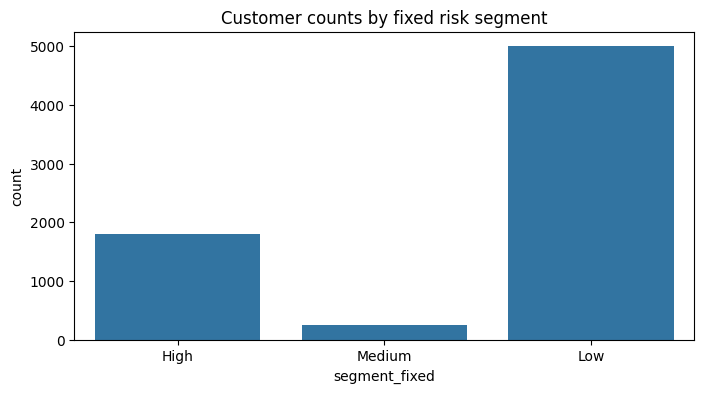

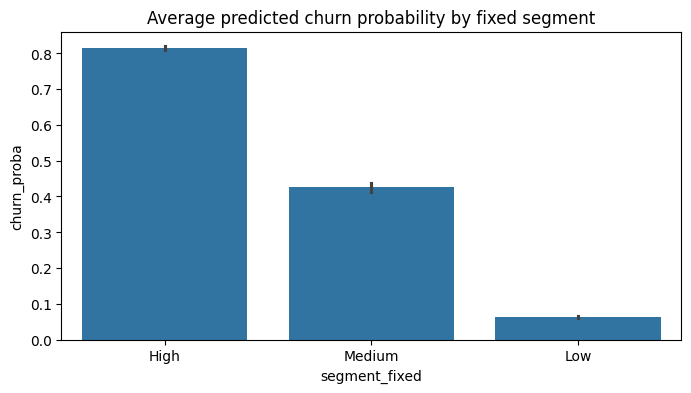

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='segment_fixed', order=['High','Medium','Low'])
plt.title('Customer counts by fixed risk segment')
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=df, x='segment_fixed', y='churn_proba', order=['High','Medium','Low'])
plt.title('Average predicted churn probability by fixed segment')
plt.show()

### 7. Retention strategy recommendations (qualitative)
- High-Risk (Top-prob): offer strong retention offers, VIP outreach, quick retention calls, immediate discounts, personalized retention bundles.
- Medium-Risk: nurture campaigns, targeted promotions, improved support touchpoints, incentives for longer contracts.
- Low-Risk: upsell/cross-sell, loyalty programs, gather referrals.

In [17]:
strategy_df = pd.DataFrame([
    {'segment': 'High', 'actions': 'Retention call + personalized discount; 1:1 support; save-to-contract incentives', 'goal': 'Prevent immediate churn (reduce FN)'},
    {'segment': 'Medium', 'actions': 'Targeted email + promo; trial add-on services; customer success outreach', 'goal': 'Improve satisfaction and reduce mid-term churn'},
    {'segment': 'Low', 'actions': 'Upsell offers + loyalty rewards; referral program', 'goal': 'Grow ARPU and lifetime value'}
])
display(strategy_df)


,segment,actions,goal
0,High,Retention call + personalized discount; 1:1 su...,Prevent immediate churn (reduce FN)
1,Medium,Targeted email + promo; trial add-on services;...,Improve satisfaction and reduce mid-term churn
2,Low,Upsell offers + loyalty rewards; referral program,Grow ARPU and lifetime value


### 8. ROI calculations: define a scenario and functions to compute expected savings, costs, and ROI.

In [18]:
# Business parameters
SCENARIO = {
    'cost_per_contact': 10.0,          # cost to reach one customer (call/email/offer)
    'campaign_success_rate': 0.20,     # probability that contact prevents churn for a customer who would have churned
    'months_saved_on_success': 6       # months of revenue retained if we prevent churn
}

# compute per-customer expected value (EV) of targeting:
avg_monthly = df['MonthlyCharges'].mean()  # average bill
print('Avg monthly charge (dataset):', round(avg_monthly,2))

def expected_savings_for_customer(p_churn: float, success_rate: float, months_saved: int, monthly_value: float) -> float:

    return p_churn * success_rate * (monthly_value * months_saved)

def campaign_metrics_for_segment(df_segment, cost_per_contact, success_rate, months_saved, monthly_value):
  
    n = len(df_segment)
    # expected saved revenue per customer
    ev_per_customer = df_segment['churn_proba'].apply(lambda p: expected_savings_for_customer(p, success_rate, months_saved, monthly_value))
    total_ev_saved = ev_per_customer.sum()
    total_cost = n * cost_per_contact
    net_gain = total_ev_saved - total_cost
    roi = net_gain / total_cost if total_cost>0 else np.nan
    return {'n_customers': n, 'total_ev_saved': total_ev_saved, 'total_cost': total_cost, 'net_gain': net_gain, 'roi': roi, 'ev_per_customer_mean': ev_per_customer.mean()}

# Evaluate for each segment (fixed segmentation)
results = {}
for seg in ['High','Medium','Low']:
    seg_df = df[df['segment_fixed']==seg]
    results[seg] = campaign_metrics_for_segment(seg_df, SCENARIO['cost_per_contact'], SCENARIO['campaign_success_rate'], SCENARIO['months_saved_on_success'], avg_monthly)

pd.DataFrame(results).T.round(2)


Avg monthly charge (dataset): 64.76


,n_customers,total_ev_saved,total_cost,net_gain,roi,ev_per_customer_mean
High,1794.0,113702.09,17940.0,95762.09,5.34,63.38
Medium,250.0,8260.99,2500.0,5760.99,2.30,33.04
Low,4999.0,24524.44,49990.0,-25465.56,-0.51,4.91


### 9. Scenario analysis (vary campaign_success_rate and cost_per_contact)

,segment,cost_per_contact,success_rate,n_customers,total_ev_saved,total_cost,net_gain,roi,ev_per_customer_mean
0,High,5,0.05,1794,28425.52,8970,19455.52,2.17,15.84
1,High,5,0.10,1794,56851.05,8970,47881.05,5.34,31.69
2,High,5,0.20,1794,113702.09,8970,104732.09,11.68,63.38
3,High,5,0.30,1794,170553.14,8970,161583.14,18.01,95.07
4,High,10,0.05,1794,28425.52,17940,10485.52,0.58,15.84
5,High,10,0.10,1794,56851.05,17940,38911.05,2.17,31.69
6,High,10,0.20,1794,113702.09,17940,95762.09,5.34,63.38
7,High,10,0.30,1794,170553.14,17940,152613.14,8.51,95.07
8,High,20,0.05,1794,28425.52,35880,-7454.48,-0.21,15.84
9,High,20,0.10,1794,56851.05,35880,20971.05,0.58,31.69


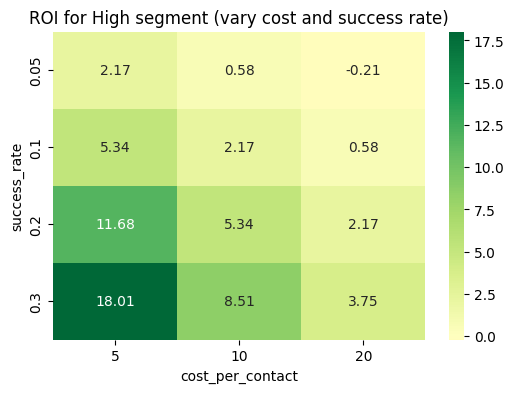

In [19]:
def run_scenarios(df, segment='High', cost_grid=[5,10,20], success_grid=[0.1,0.2,0.4], months_saved=6):
    outputs = []
    seg_df = df[df['segment_fixed']==segment]
    for cost in cost_grid:
        for success in success_grid:
            m = campaign_metrics_for_segment(seg_df, cost, success, months_saved, avg_monthly)
            outputs.append({'segment':segment, 'cost_per_contact':cost, 'success_rate':success, **m})
    return pd.DataFrame(outputs)

scenario_df = run_scenarios(df, 'High', cost_grid=[5,10,20], success_grid=[0.05,0.10,0.2,0.3])
display(scenario_df.round(2))

# plot ROI surface (cost vs success)
pivot = scenario_df.pivot(index='success_rate', columns='cost_per_contact', values='roi')
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('ROI for High segment (vary cost and success rate)')
plt.show()


### 10. Prioritization & Resource Allocation (simple rule-of-thumb)
1. Run a small pilot on the High segment to estimate actual campaign_success_rate and cost_per_contact.
2. If pilot ROI > 0 and lifts churn reduction, scale up to larger High segment; evaluate Medium segment next.
3. For Low segment prioritize upsell strategies (different KPI).


In [20]:
# Compute ROI
roi_summary = pd.DataFrame(results).T.reset_index().rename(columns={'index':'segment'})
roi_summary = roi_summary.merge(strategy_df, on='segment', how='left')
display(roi_summary[['segment','n_customers','total_ev_saved','total_cost','net_gain','roi','actions']].round(2))

,segment,n_customers,total_ev_saved,total_cost,net_gain,roi,actions
0,High,1794.0,113702.09,17940.0,95762.09,5.34,Retention call + personalized discount; 1:1 su...
1,Medium,250.0,8260.99,2500.0,5760.99,2.30,Targeted email + promo; trial add-on services;...
2,Low,4999.0,24524.44,49990.0,-25465.56,-0.51,Upsell offers + loyalty rewards; referral program


### 11. Save results & top-customer lists for campaign execution

In [21]:
out_dir = Path('reports')
out_dir.mkdir(parents=True, exist_ok=True)

# Save scored dataset and segment lists
df.to_csv(out_dir / 'scored_customers.csv', index=False)
# Save top N high-risk customers for immediate contact
topN = 100
top_customers = df.sort_values('churn_proba', ascending=False).head(topN)
top_customers.to_csv(out_dir / 'top100_high_risk_customers.csv', index=False)

# Save ROI scenario table
scenario_df.to_csv(out_dir / 'roi_scenarios_high_segment.csv', index=False)

print('Saved scored dataset and campaign lists to', out_dir.resolve())
print('Sample top customers (top 5):')
display(top_customers.head())


Saved scored dataset and campaign lists to E:\Projects\mini-project\reports
Sample top customers (top 5):


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Churn,tenure_group,services_count,avg_charge_per_month,churn_proba,segment_fixed,segment_quantile,segment_costopt
3310,9885-CSMWE,Female,1,No,No,1,Yes,No,Fiber optic,No,...,78.45,78.45,Yes,0 months,2.0,78.45,1.0,High,High,High
2367,0235-KGSLC,Female,0,No,No,1,Yes,No,Fiber optic,No,...,85.55,85.55,Yes,0 months,3.0,85.55,1.0,High,High,High
3294,1086-LXKFY,Female,0,Yes,Yes,1,Yes,No,Fiber optic,No,...,69.10,69.10,Yes,0 months,1.0,69.10,1.0,High,High,High
3216,7250-EQKIY,Female,0,Yes,Yes,1,Yes,No,DSL,No,...,50.45,50.45,Yes,0 months,2.0,50.45,1.0,High,High,High
3906,6372-RFVNS,Female,0,Yes,No,1,Yes,No,Fiber optic,No,...,78.80,78.80,Yes,0 months,2.0,78.80,1.0,High,High,High
